In [56]:
import xarray as xr
import dask
import numpy as np
from datetime import datetime, timedelta
from cartopy.feature.nightshade import Nightshade
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os, glob, sys, gc
from tqdm.auto import tqdm
import pandas as pd

In [57]:
import argparse
import glob
import os
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

import numpy as np
import xarray as xr

import importlib


In [3]:
os.chdir('SAMI3-GITM-python/')

In [4]:
import utility_programs.filters as filters
from utility_programs.plotting_routines import panel_plot
from utility_programs.read_routines.GITM import auto_read as auto_read_gitm
from utility_programs.read_routines.GITM import gitm_times_from_filelist
from utility_programs.read_routines.SAMI import auto_read as auto_read_sami
from utility_programs import plotting_routines
from utility_programs.utils import ut_to_lt

/glade/u/home/abukowski/SAMI3-GITM-python/utility_programs/plotting_routines.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


# Read in all Rot B Datasets:

In [5]:
gitms = {}
samis = {}

for file in np.sort(glob.glob('/glade/u/home/abukowski/scratch/postprocessed/*')):
    if 'rotB' in file:
        relevant = file[file.find('rotB-'):]
        bz = relevant.split('_')[0].split('-')[1:]
        
        if len(bz) == 1:
            if 'GITM' in file:
                if len(gitms.keys()) > 0:
                    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
                        gitms['-'.join(bz)] = xr.open_mfdataset(file).reindex_like(gitms[gitm_key0], method='nearest')
                else:
                    gitms['-'.join(bz)] = xr.open_mfdataset(file)
                    gitm_key0 = '-'.join(bz)
            elif 'SAMI' in file:
                samis['-'.join(bz)] = xr.open_mfdataset(file)
            else:
                print('file %s error' %file)
        
        elif len(bz) == 2:
            if 'GITM' in file:
                if len(gitms.keys()) > 0:
                    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
                        gitms['-'.join(bz)] = xr.open_mfdataset(file).reindex_like(gitms[gitm_key0], method='nearest')
                else:
                    gitms['-'.join(bz)] = xr.open_mfdataset(file)
                    gitm_key0 = '-'.join(bz)
            elif 'SAMI' in file:
                samis['-'.join(bz)] = xr.open_mfdataset(file)
            else:
                print('file %s error' %file)            
        


In [69]:
def map_and_dials(dial_da,
                  total,
                  map_da=None,
                  max_per_row=3,
                  isel_dials=None,
                  sel_dials=None,
                  isel_map=None,
                  sel_map=None,
                  quiver_map_cols=None,
                  suptitle=None,
                  time_start=None,
                  time_delta='1 hour',
                  save=None,
                  mask_dials=0.001,
                  dial_cmap='rainbow',
                  dial_JH_defaults=True,
                  map_cmap='rainbow',
                  vmin_dial=None,
                  vmax_dial=None,
                  vmin_map=None,
                  vmax_map=None,
                  several_datasets=False,
                  times_datasets=None):

    # setup data:
    if max_per_row is None:
        max_per_row = 3

    if isel_map is None and sel_map is None:
        times = [pd.Timestamp(time_start) +
                 pd.Timedelta(time_delta)*i for i in range(total)]
        sel_map = {'time': times}

    if isel_dials is None and sel_dials is None:
        times = [pd.Timestamp(time_start) +
                 pd.Timedelta(time_delta)*i for i in range(total)]
        sel_dials = {'time': times}

    # If no colorbar limits are defined, make them for the user.

    # setup figure
    nrows = int(np.ceil(total/max_per_row))
    ncols = max_per_row

    fig = plt.figure(figsize=(5*ncols, 5*nrows))

    gs0 = gridspec.GridSpec(nrows, ncols,
                            figure=fig)

    axs = []

    subgrids = []

    # keep track of times
    times_plotted = []

    for i in range(total):
        # make figure
        subgrids.append(gs0[i].subgridspec(2, 2))

        if several_datasets:
            dial_data = dial_da[list(dial_da.data_vars)[i]]
            map_data = map_da[list(map_da.data_vars)[i]]
            # for local time:
            time_here = pd.Timestamp(dial_data.time.values)

        else:
            # get data (first dial then map):
            if isel_dials is None:
                new = {}
                new[list(sel_dials.keys())[0]] = list(sel_dials.values())[0][i]
                dial_data = dial_da.sel(new, method='nearest')
            else:
                new = {}
                new[list(isel_dials.keys())[0]] = list(
                    isel_dials.values())[0][i]
                dial_data = dial_da.sel(new)

            if isel_map is None:
                new = {}
                new[list(sel_map.keys())[0]] = list(sel_map.values())[0][i]
                map_data = map_da.sel(new, method='nearest')
            else:
                new = {}
                new[list(isel_map.keys())[0]] = list(isel_map.values())[0][i]
                map_data = map_da.sel(new)

        # for local time:
        if times_datasets is None:
            time_here = pd.Timestamp(dial_data.time.values)
        else:
            time_here = pd.Timestamp(times_datasets[i])
        # Find central longitude (midnight Local time)
        lons = np.arange(0, 360)
        lts = ut_to_lt([time_here], lons)
        central_lon = lons[np.argmin(np.abs(24-lts))]

        if mask_dials != False:
            dial_data = dial_data.where(np.abs(dial_data) > mask_dials)

        axs.append(fig.add_subplot(
            subgrids[-1][0, 0], projection=ccrs.Orthographic(central_lon, 90)))
        dial_data.plot(ax=axs[-1], x='lon', transform=ccrs.PlateCarree(),
                       cmap=dial_cmap, cbar_kwargs={'label': "", },
                       vmin=vmin_dial, vmax=vmax_dial)
        axs[-1].set_title('')
        axs[-1].add_feature(Nightshade(time_here), alpha=0.3)

        axs.append(fig.add_subplot(
            subgrids[-1][0, 1], projection=ccrs.Orthographic(central_lon-180, -90)))
        dial_data.plot(ax=axs[-1], x='lon', transform=ccrs.PlateCarree(),
                       cmap=dial_cmap, cbar_kwargs={'label': "", },
                       vmin=vmin_dial, vmax=vmax_dial)
        axs[-1].set_title('')
        axs[-1].add_feature(Nightshade(time_here), alpha=0.3)

        axs.append(fig.add_subplot(
            subgrids[-1][1, :], projection=ccrs.PlateCarree()))

        if quiver_map_cols is None:
            map_data.plot(ax=axs[-1], x='lon', transform=ccrs.PlateCarree(),
                          cmap=map_cmap, cbar_kwargs={'label': "", },
                          vmin=vmin_map, vmax=vmax_map)
        else:
            if quiver_map_cols[2] == 'amp':
                map_data[quiver_map_cols[2]] = np.sqrt(
                    map_data[quiver_map_cols[0]]**2
                    + map_data[quiver_map_cols[1]]**2)
            map_data[quiver_map_cols[2]].plot(ax=axs[-1], x='lon', transform=ccrs.PlateCarree(),
                                              cmap=map_cmap,
                                              cbar_kwargs={'label': ""},
                                              vmin=vmin_map, vmax=vmax_map)
            map_data.coarsen(lat=3, lon=2,).mean().where(np.abs(map_data.lat) < 84)\
                .plot.quiver(x='lon', y='lat', u=quiver_map_cols[0], v=quiver_map_cols[1],
                             ax=axs[-1], transform=ccrs.PlateCarree(),
                             add_guide=False)

        if not several_datasets:
            axs[-1].set_title(str(time_here))
        else:
            axs[-1].set_title(list(map_da.data_vars)[i])
        axs[-1].add_feature(Nightshade(time_here), alpha=0.3)

        # if subtitle is None:
        #     axs[-1].set_title(str(time_here))
        # else:
        #     axs[-1].set_title(subtitle[i])

        times_plotted.append(time_here)

    times_plotted = np.array([times_plotted for i in range(total)]).flatten()
    for t, ax in enumerate(axs):
        ax.coastlines(zorder=3, color='black', alpha=1)
        ax.gridlines(color='black', linestyle='--', alpha=0.6)

    plt.suptitle(suptitle)

    fig.tight_layout()

    if save is not None:
        plt.savefig(save)
        plt.close()
    else:
        return fig

In [67]:
k='bz17'
a=450
t='2011-11-21 11:30'




# _ = map_and_dials(dial_da=gitms[k].AltIntJouleHeating_W_m2,
#               total=6,
#               map_da=gitms[k].Vn_north.sel(alt=a, method='nearest'),
#               max_per_row=3, mask_dials=0.002,
#               suptitle='Joule Heating (W/m2) and Vn_North (m/s) at %i km from run %s' % (a, k),
#               time_start=t,
#               map_cmap='bwr', vmin_dial=0.03, vmax_dial=.11, vmin_map=None, vmax_map=None)
# plt.show()


# map_and_dials(dial_da=gitms[k].AltIntJouleHeating_W_m2,
#               total=6,
#               map_da=gitms[k].sel(alt=a, method='nearest'),
#               max_per_row=3, mask_dials=0.002,
#               suptitle='Joule Heating (W/m2) and Temperature at %i km from run %s' % (a, k),
#               time_start=t,
#               quiver_map_cols=['Vn_east', 'Vn_north', 'Temperature'],
#               map_cmap='bwr', vmin_dial=0.03, vmax_dial=.11, vmin_map=None, vmax_map=None)
# plt.show()

# map_and_dials(dial_da=gitms[k].AltIntJouleHeating_W_m2,
#               total=6,
#               map_da=filters.filter_xarray_DA_diff(gitms[k].sel(alt=a, method='nearest'),
#                                                    percent=False, label='lower', order=2),
#               max_per_row=3, mask_dials=0.002,
#               suptitle='Joule Heating (W/m2) and Horizontal Velocity Amplitude at %i km from run %s' % (a, k),
#               time_start=t,
#               map_processes = 'filter_by_diff',
#               # process_nargs=None,
#               quiver_map_cols=['Vn_east', 'Vn_north', 'amp'],
#               map_cmap='bwr', vmin_dial=0.03, vmax_dial=.11, vmin_map=None, vmax_map=None)
# plt.show()


map_and_dials(dial_da=gitms[k].AltIntJouleHeating_W_m2,
              total=6,
              map_da=gitms[k].sel(alt=a, method='nearest'),
              max_per_row=3, mask_dials=0.002,
              suptitle='Joule Heating (W/m2) and Horizontal Velocity Amplitude at %i km from run %s' % (a, k),
              time_start=t,
              quiver_map_cols=['Vn_east', 'Vn_north', 'amp'],
              map_cmap='bwr', vmin_dial=0.03, vmax_dial=.11, vmin_map=None, vmax_map=None)
plt.show()

TypeError: map_and_dials() got an unexpected keyword argument 'map_processes'

starting loop


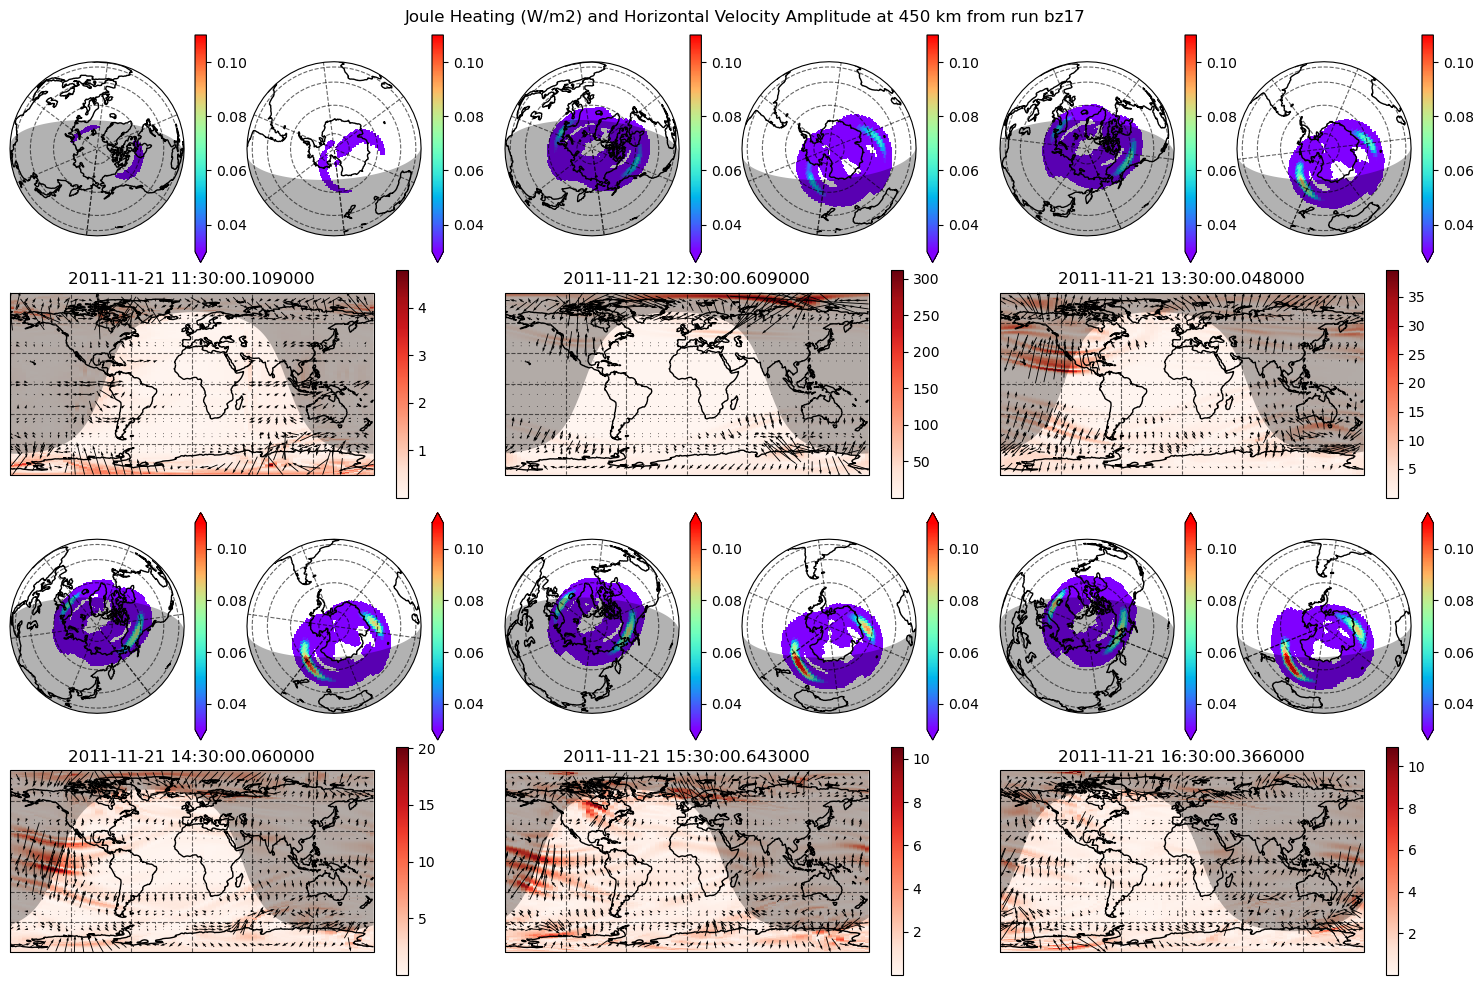

In [70]:
map_and_dials(dial_da=gitms[k].AltIntJouleHeating_W_m2,
              total=6,
              map_da=filters.filter_xarray_DA_diff(gitms[k].sel(alt=a, method='nearest'),
                                                   percent=False, label='lower', order=2),
              max_per_row=3, mask_dials=0.002,
              suptitle='Joule Heating (W/m2) and Horizontal Velocity Amplitude at %i km from run %s' % (a, k),
              time_start=t,
              quiver_map_cols=['Vn_east', 'Vn_north', 'amp'],
              map_cmap='Reds', vmin_dial=0.03, vmax_dial=.11, vmin_map=None, vmax_map=None)
plt.show()